In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import tonic
import numpy as np
from tqdm import tqdm
import cv2

import albumentations as A
from EvEye.utils.visualization.visualization import visualize
from EvEye.utils.tonic.functional.ToFrameStack import to_frame_stack_numpy
from EvEye.dataset.DavisEyeCenter.MemmapDavisEyeCenterDataset import MemmapDavisEyeCenterDataset

In [4]:
dataset = MemmapDavisEyeCenterDataset(
    root_path="/mnt/data2T/junyuan/eye-tracking/datasets/MemmapDavisEyeCenterDataset",
    split="train",
    time_window=40000,
    frames_per_segment=50,
    sensor_size=(346, 260, 2),
    events_interpolation="causal_linear",  # 'bilinear', 'nearest', 'causal_linear'
    max_count=5,
    spatial_factor = 0.5,
)
event, label, _ = dataset[10000]

In [5]:
event = np.transpose(event, (1, 0, 2, 3))
label[0] *= 173
label[1] *= 130
label = np.transpose(label, (1, 0))
label = np.around(label).astype(int)
event.shape, label.shape

((50, 2, 130, 173), (50, 2))

In [6]:
event.max(), label[0]

(1.0, array([103,  81]))

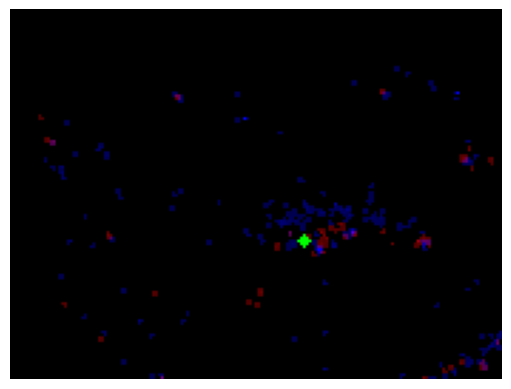

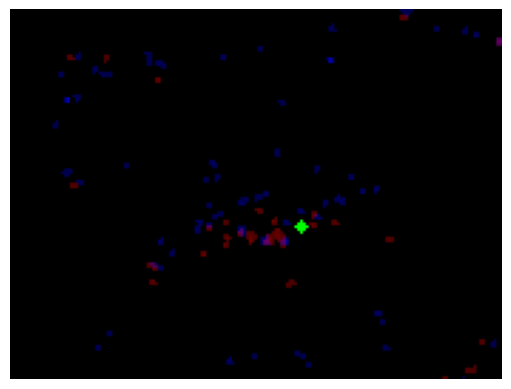

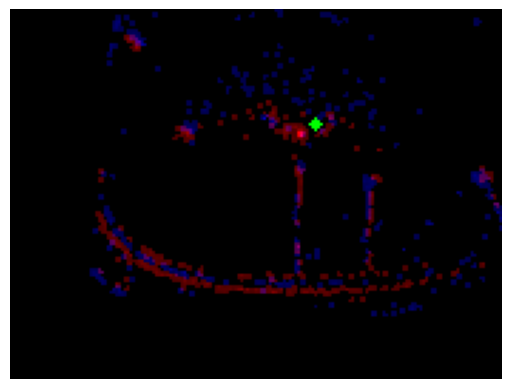

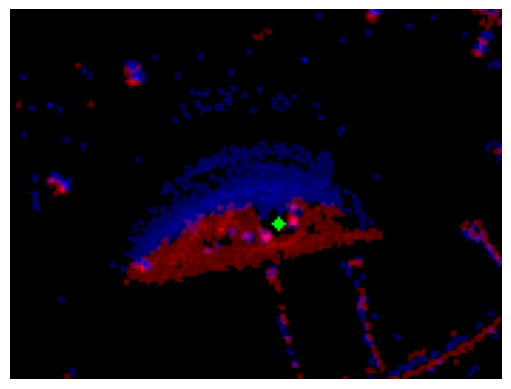

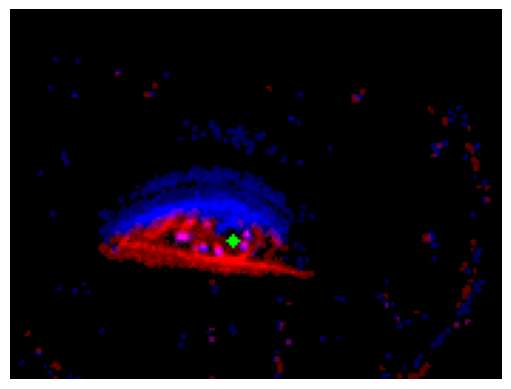

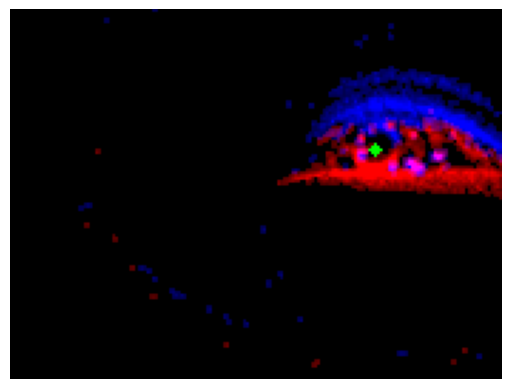

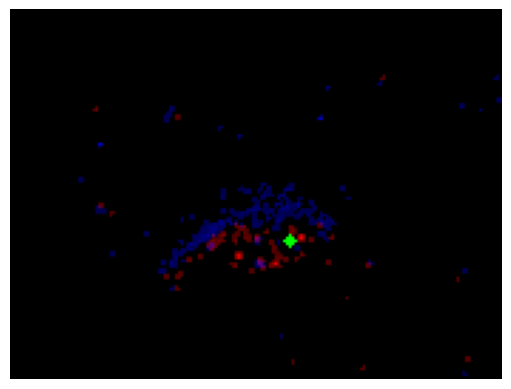

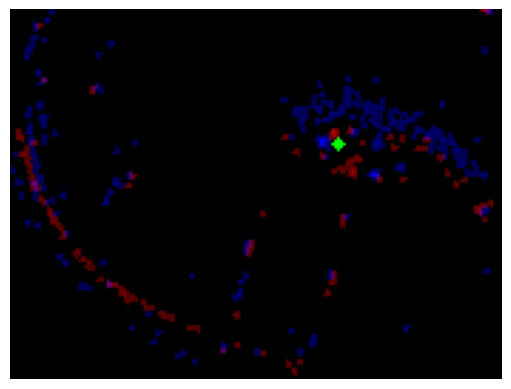

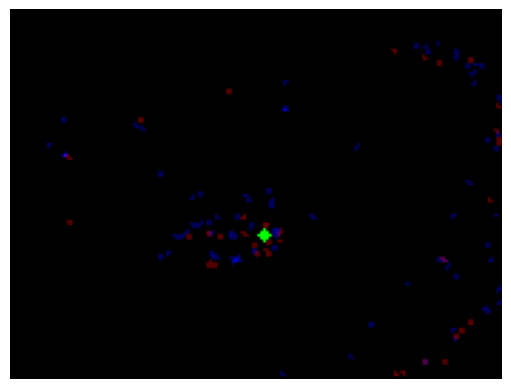

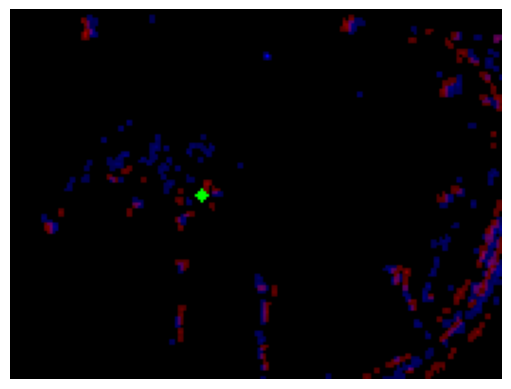

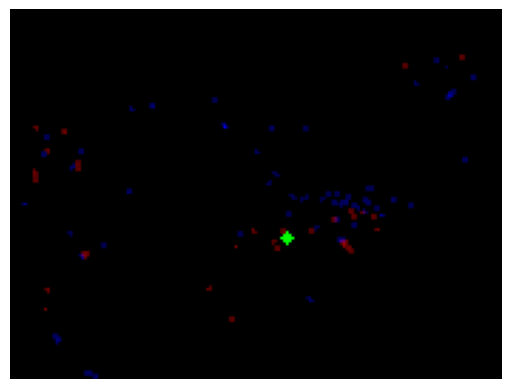

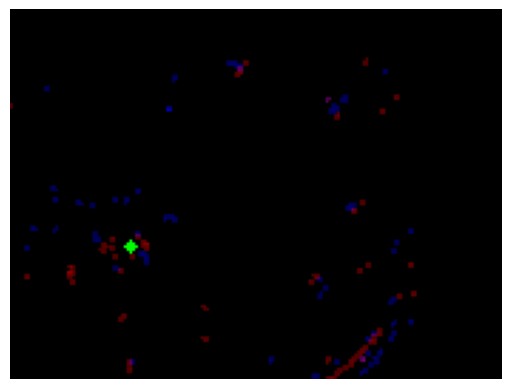

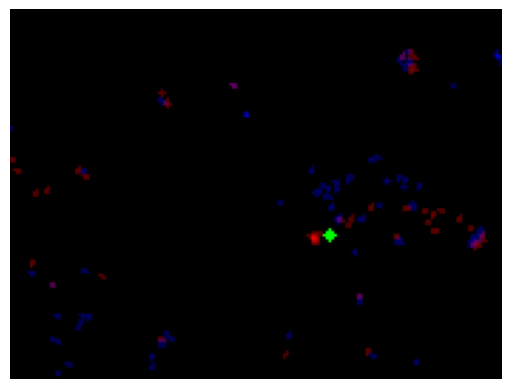

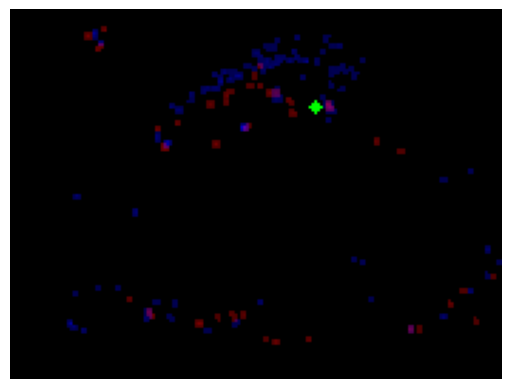

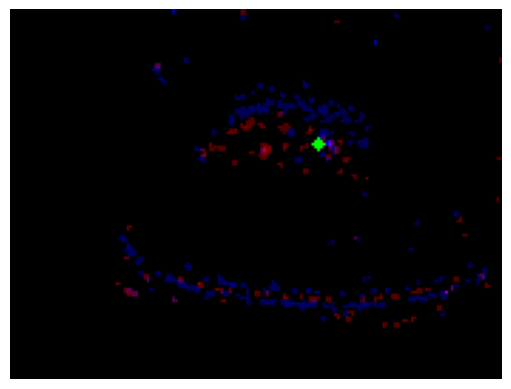

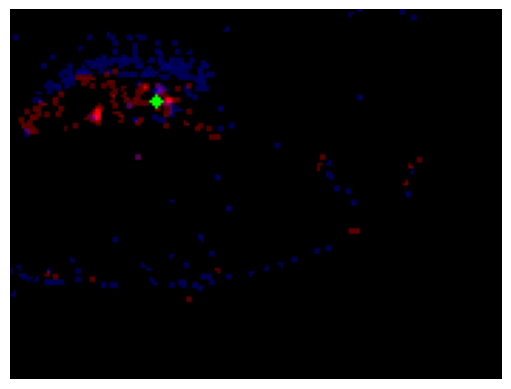

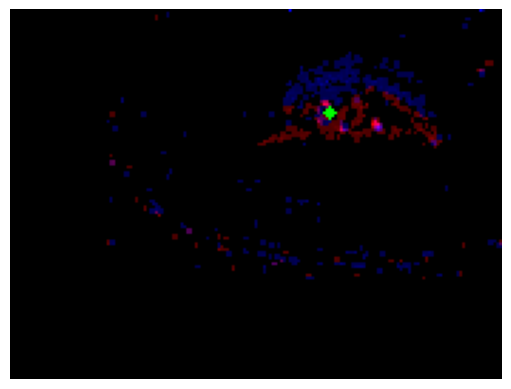

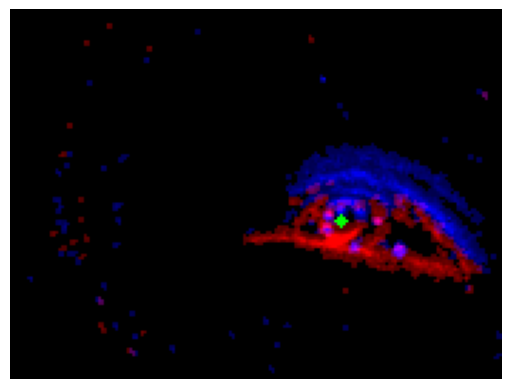

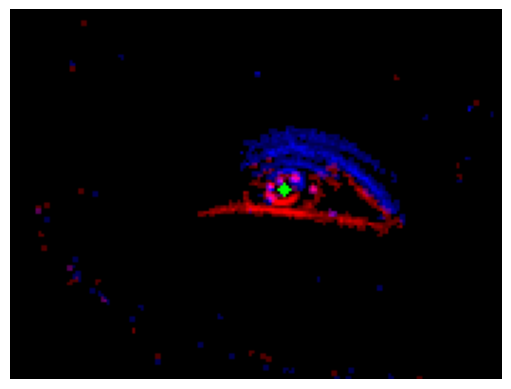

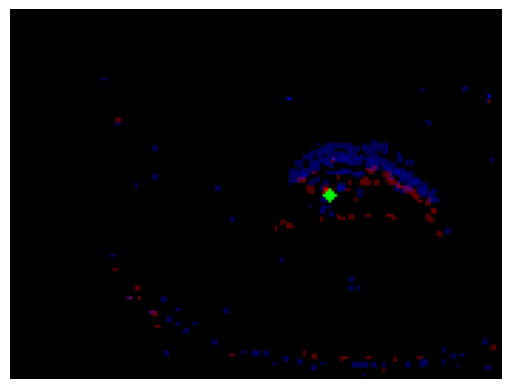

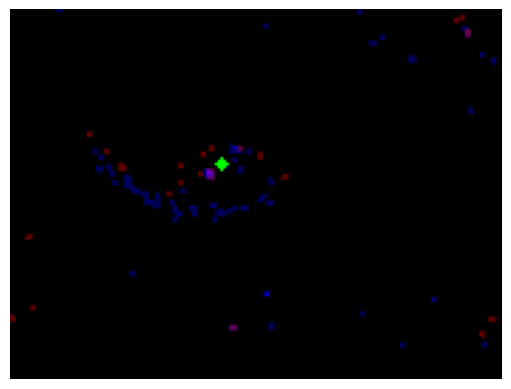

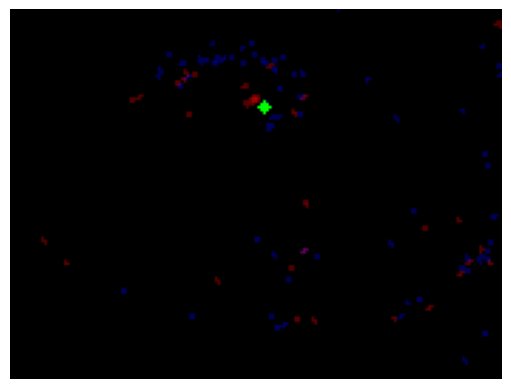

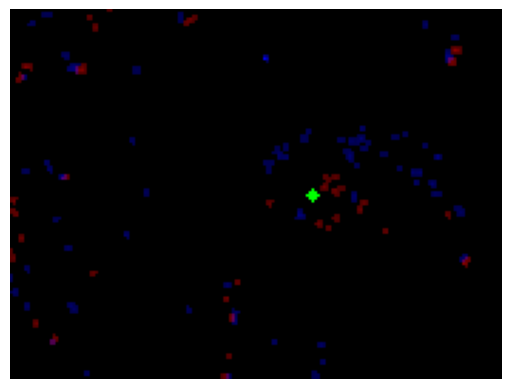

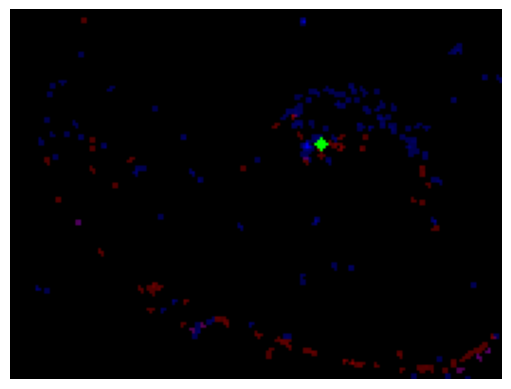

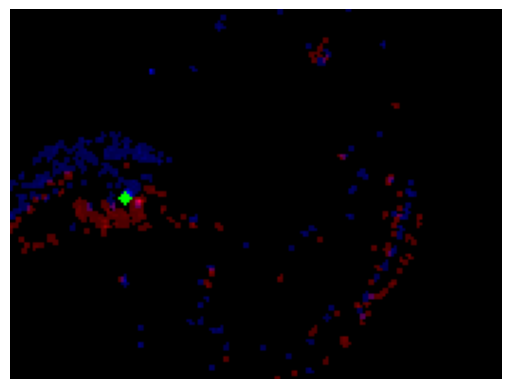

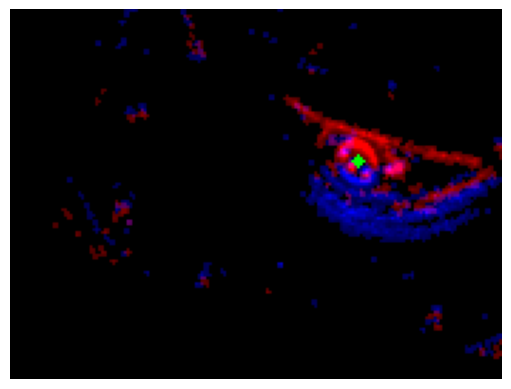

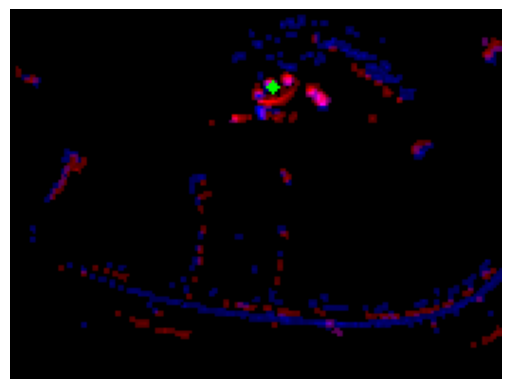

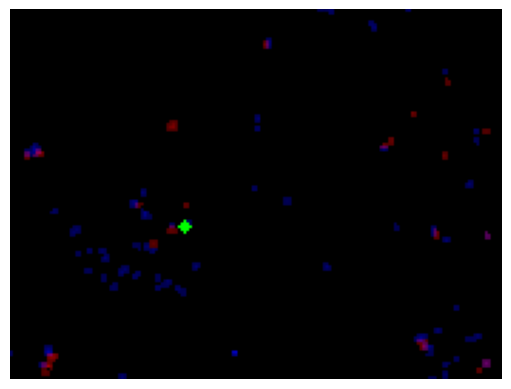

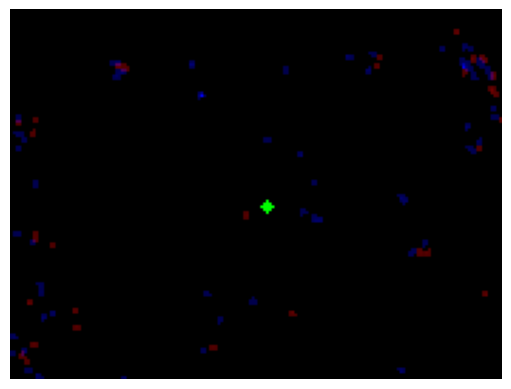

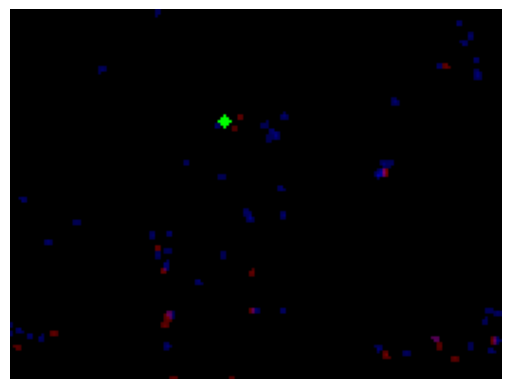

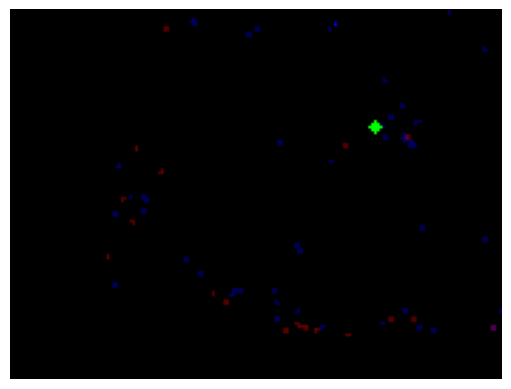

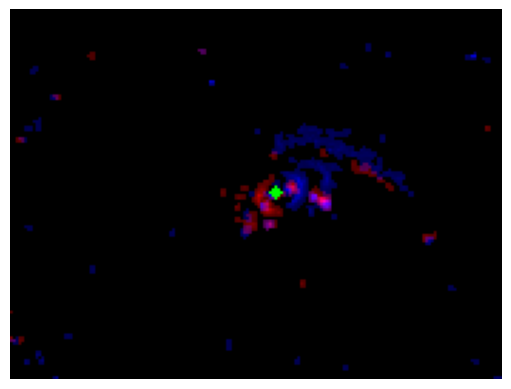

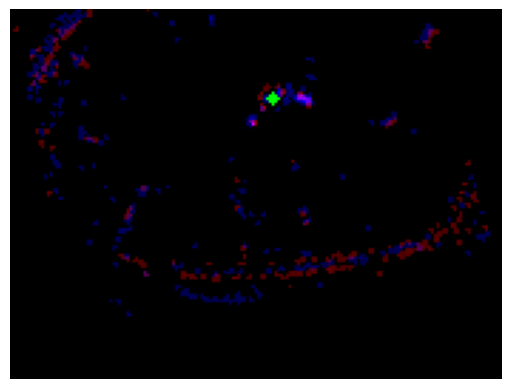

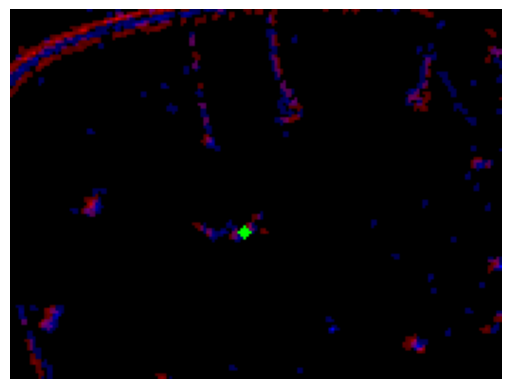

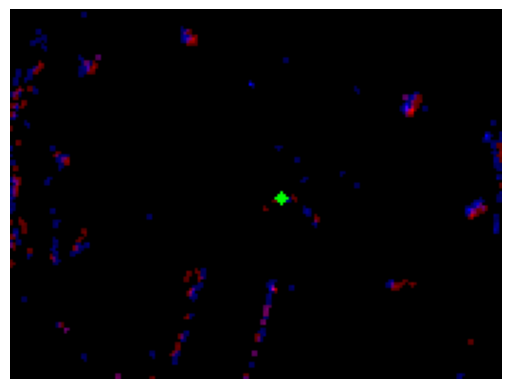

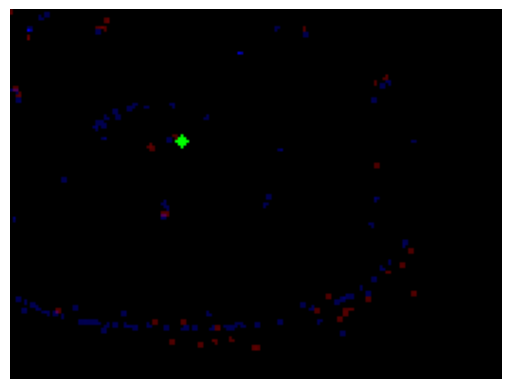

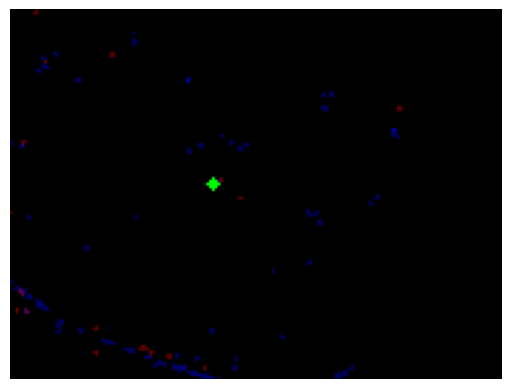

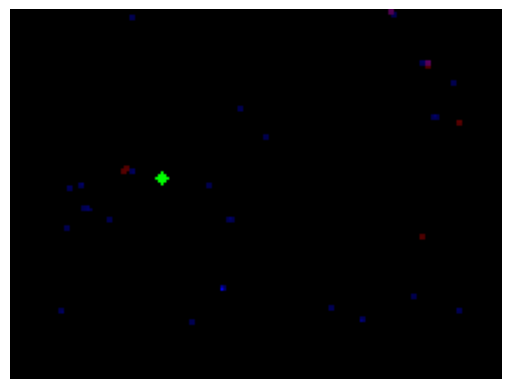

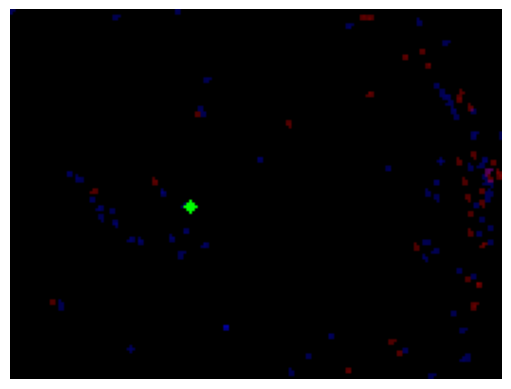

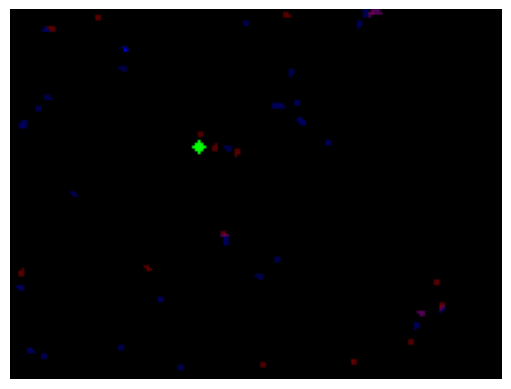

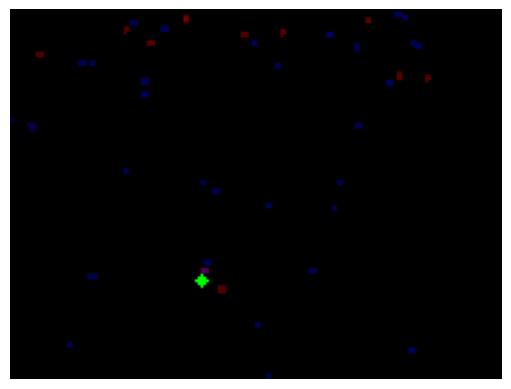

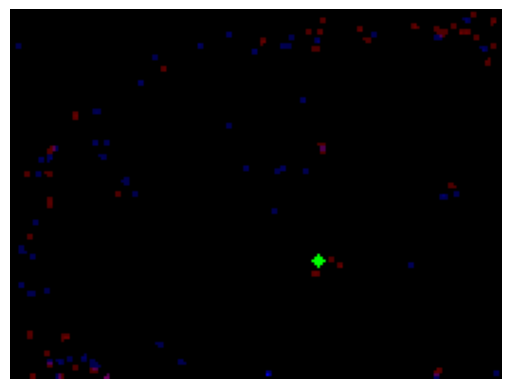

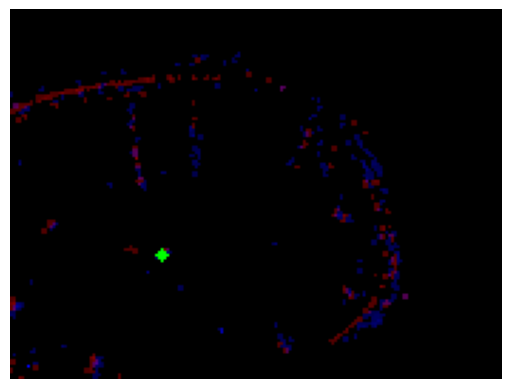

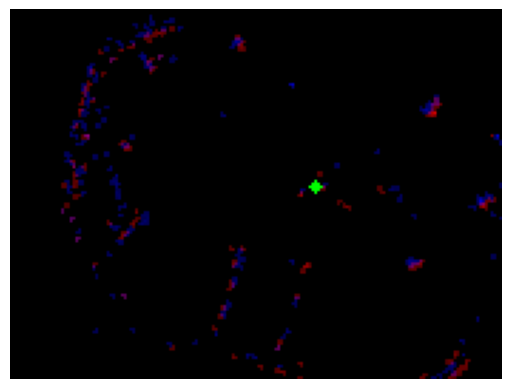

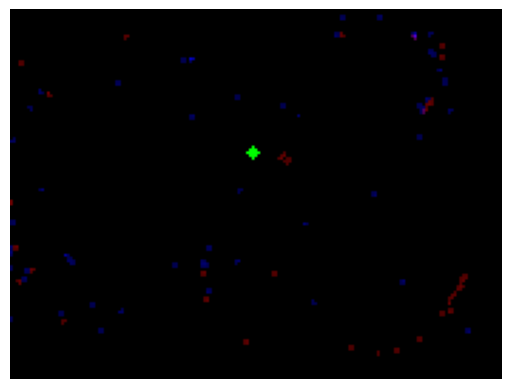

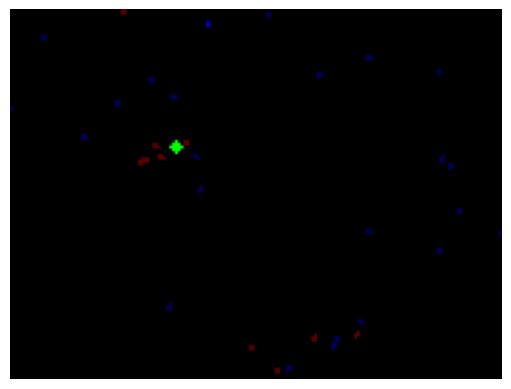

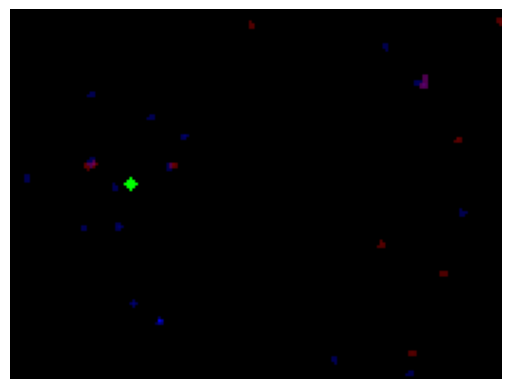

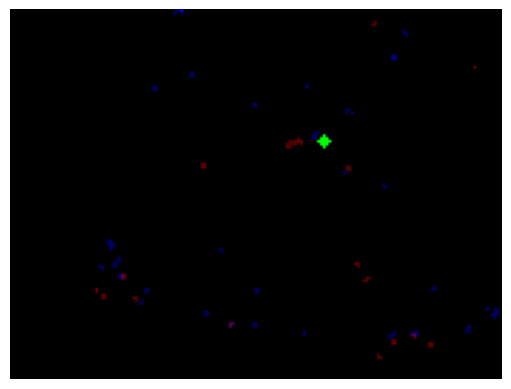

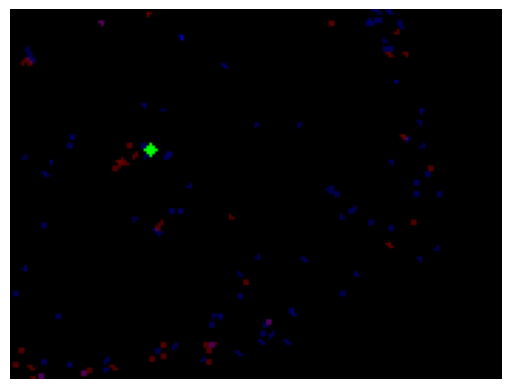

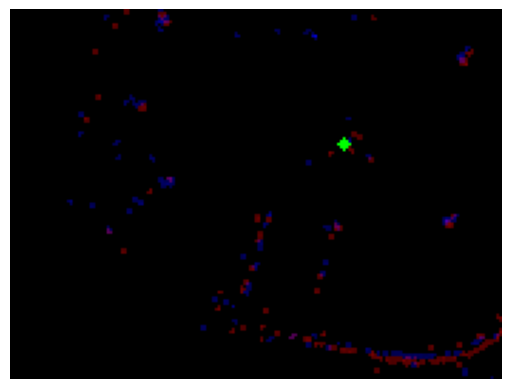

In [7]:
event_vis = visualize(event, normalized=True, add_weight=0.3)
for i in range(event_vis.shape[0]):
    center_x, center_y = label[i][0], label[i][1]
    cv2.circle(event_vis[i], (center_x, center_y), 2, (0, 255, 0), -1)
    plt.axis('off')
    plt.imshow(event_vis[i])
    plt.show()

In [8]:
from EvEye.utils.processor.TxtProcessor import TxtProcessor

event_path = "/mnt/data2T/junyuan/eye-tracking/TestEvents.txt"
txt_processor = TxtProcessor(event_path)
data = txt_processor.load_events_from_txt()

FileNotFoundError: /mnt/data2T/junyuan/eye-tracking/TestEvents.txt not found.

In [ ]:
label_path = "/mnt/data2T/junyuan/eye-tracking/TestLabels.txt"
txt_processor = TxtProcessor(label_path)
label = txt_processor.load_labels_from_txt()

In [ ]:
sensor_size = (346, 260, 2)
frame_stack = to_frame_stack_numpy(data, sensor_size, 10, "causal_linear")
labels = np.stack([label["x"], label["y"]], axis=1)
frame_stack.shape, labels.shape

In [ ]:
frame_stack_flipped = frame_stack[::-1, ::-1, :, :]
labels_flipped = labels[::-1, :]

In [ ]:
frame_stack_vis = visualize(frame_stack)
frame_stack_flipped_vis = visualize(frame_stack_flipped)
for i in range(frame_stack.shape[0]):
    cv2.circle(frame_stack_vis[i], (labels[i, 0], labels[i, 1]), 3, (255, 255, 255), -1)
    cv2.circle(
        frame_stack_flipped_vis[i],
        (labels_flipped[i, 0], labels_flipped[i, 1]),
        3,
        (255, 255, 255),
        -1,
    )
    frame = np.concatenate([frame_stack_vis[i], frame_stack_flipped_vis[i]], axis=1)
    plt.imshow(frame)
    plt.show()

In [ ]:
transforms = A.Compose(
    [
        A.Resize(height=130, width=173, interpolation=cv2.INTER_LINEAR),
        A.Normalize(mean=(0.0, 0.0), std=(1.0, 1.0)),
        # A.Rotate(limit=45, p=1),
    ],
    keypoint_params=A.KeypointParams(format="xy"),
)

In [ ]:
for i in range(frame_stack.shape[0]):
    canvas = np.zeros((frame_stack.shape[0], 2, 130, 173))
    frame = frame_stack[i]
    frame = np.transpose(frame, (1, 2, 0))  # 转换为 (260, 346, 2)
    print("Original frame shape:", frame.shape)

    label = [tuple(labels[i])]  # 将关键点转换为元组列表
    print("Original keypoints:", label)

    # 对 frame 和 keypoints 使用 transforms
    transformed = transforms(image=frame, keypoints=label)
    frame = transformed["image"]
    label = transformed["keypoints"]
    canvas[i] = np.transpose(frame, (2, 0, 1))
    labels[i] = label[0]

    # 打印变换后的 frame 和 keypoints
    print("Transformed frame shape:", frame.shape)
    print("Transformed keypoints:", label)

In [ ]:
frame_stack.shape, labels.shape, canvas.shape

In [ ]:
labels.max()

In [ ]:
canvas_vis = visualize(canvas)
frame_stack_vis = visualize(frame_stack)
for index in range(canvas_vis.shape[0]):
    center_x = labels[index][0]
    center_y = labels[index][1]
    cv2.circle(canvas_vis[index], (center_x, center_y), 3, (0, 255, 0), -1)
    plt.imshow(canvas_vis[index])
    plt.axis("off")
    plt.show()

In [ ]:
# NMNISTdataset = tonic.datasets.NMNIST(save_to='./data', train=False)
# events, target = NMNISTdataset[0]
# events.dtype, events.shape

In [ ]:
import tonic.transforms as transforms

sensor_size = (346, 260, 2)

In [ ]:
frame_transform = transforms.Downsample(spatial_factor=0.5)
frames_downsapled = frame_transform(data)
label_downsapled = frame_transform(label)
frames_downsapled.shape

In [ ]:
frames = to_frame_stack_numpy(frames_downsapled, sensor_size, 10, "causal_linear")
frames_vis = visualize(frames)

In [ ]:
for index in range(frames_vis.shape[0]):
    center_x = int(label["x"][index])
    center_y = int(label["y"][index])
    cv2.circle(frames_vis[index], (center_x, center_y), 3, (0, 255, 0), -1)
    plt.imshow(frames_vis[index])
    plt.axis("off")
    plt.show()

In [ ]:
denoise_transform = tonic.transforms.Denoise(filter_time=2000)
event_denoised = denoise_transform(data)
frames_denoised = frame_transform(event_denoised)
frames_denoised.shape

In [ ]:
voxelgrid = tonic.transforms.ToVoxelGrid(sensor_size=sensor_size, n_time_bins=10)(
    event_denoised
)
voxelgrid.shape

In [ ]:
def plot_frames(frames):
    for index in range(len(frames)):
        plt.imshow(frames[index])
        plt.axis("off")
        plt.show()

In [ ]:
frames_raw_vis = visualize(frames_raw)
frames_denoised_vis = visualize(frames_denoised)
voxelgrid_vis = visualize(voxelgrid)

In [ ]:
for index in range(frames_raw_vis.shape[0]):
    frame_vis = np.concatenate([frames_raw_vis[index], voxelgrid_vis[index]], axis=1)
    # frame_vis = cv2.cvtColor(frame_vis, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_vis)
    plt.axis("off")
    plt.show()